# 1. Import Core Libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

print("Libraries imported successfully.")

Libraries imported successfully.


# 2. Load the Dataset 

In [3]:
try:
    df = pd.read_csv('/kaggle/input/predictive-maintenance-for-industrie-4-0/ai4i2020.csv')
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'ai4i2020.csv' not found. Please ensure the dataset is in the correct directory.")
    df = pd.DataFrame()

if not df.empty:
    print("\n--- Initial Data Quality Check ---")

Dataset loaded successfully.
Dataset shape: (10000, 14)

--- Initial Data Quality Check ---


In [4]:
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("---------------------------------------------------------------")

print("\nDataset Info (Data Types and Nulls):")
df.info()

print("---------------------------------------------------------------")

print("\nDescriptive Statistics:")
print(df.describe())


First 5 rows of the dataset:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1 

In [5]:
# Remove special characters and spaces from column names.
df.columns = df.columns.str.replace('\[.*?\]', '', regex=True).str.strip().str.replace(' ', '_')
print("\nCleaned Column Names:")
print(df.columns)


Cleaned Column Names:
Index(['UDI', 'Product_ID', 'Type', 'Air_temperature', 'Process_temperature',
       'Rotational_speed', 'Torque', 'Tool_wear', 'Machine_failure', 'TWF',
       'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')


In [6]:
df = df.drop(['UDI', 'Product_ID'], axis=1)
print("\nDropped 'UDI' and 'Product_ID' columns.")


Dropped 'UDI' and 'Product_ID' columns.


 # 4. Exploratory Data Analysis

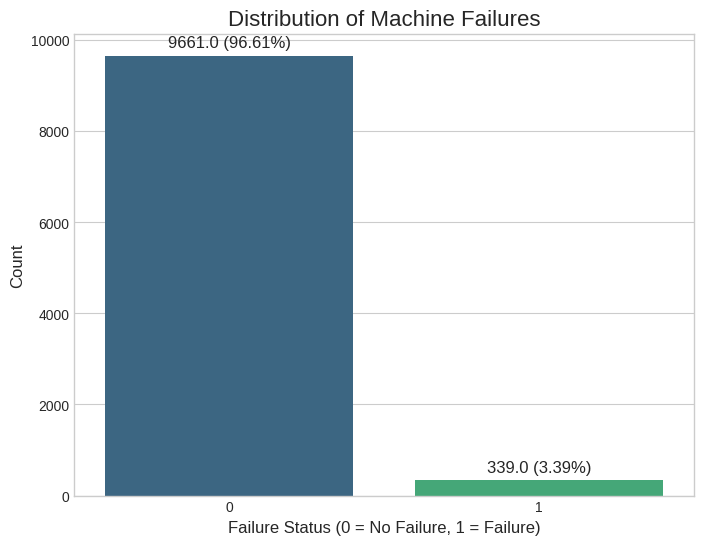

In [7]:
# Analyze the Target Variable (Class Imbalance)
if not df.empty:
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x='Machine_failure', data=df, palette='viridis')
    
    plt.title('Distribution of Machine Failures', fontsize=16)
    plt.xlabel('Failure Status (0 = No Failure, 1 = Failure)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height()} ({p.get_height()/len(df)*100:.2f}%)',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9),
                    textcoords='offset points', fontsize=12)
    plt.show()

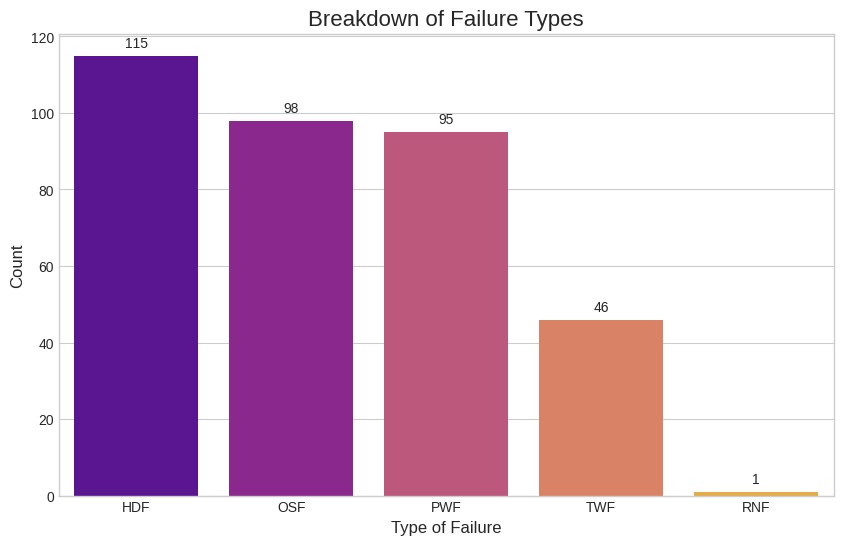

In [8]:
# Analyze Failure Types
if not df.empty:
    failure_type_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
    
    failure_counts = df[df['Machine_failure'] == 1][failure_type_cols].sum().sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette='plasma')
    plt.title('Breakdown of Failure Types', fontsize=16)
    plt.xlabel('Type of Failure', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    plt.show()

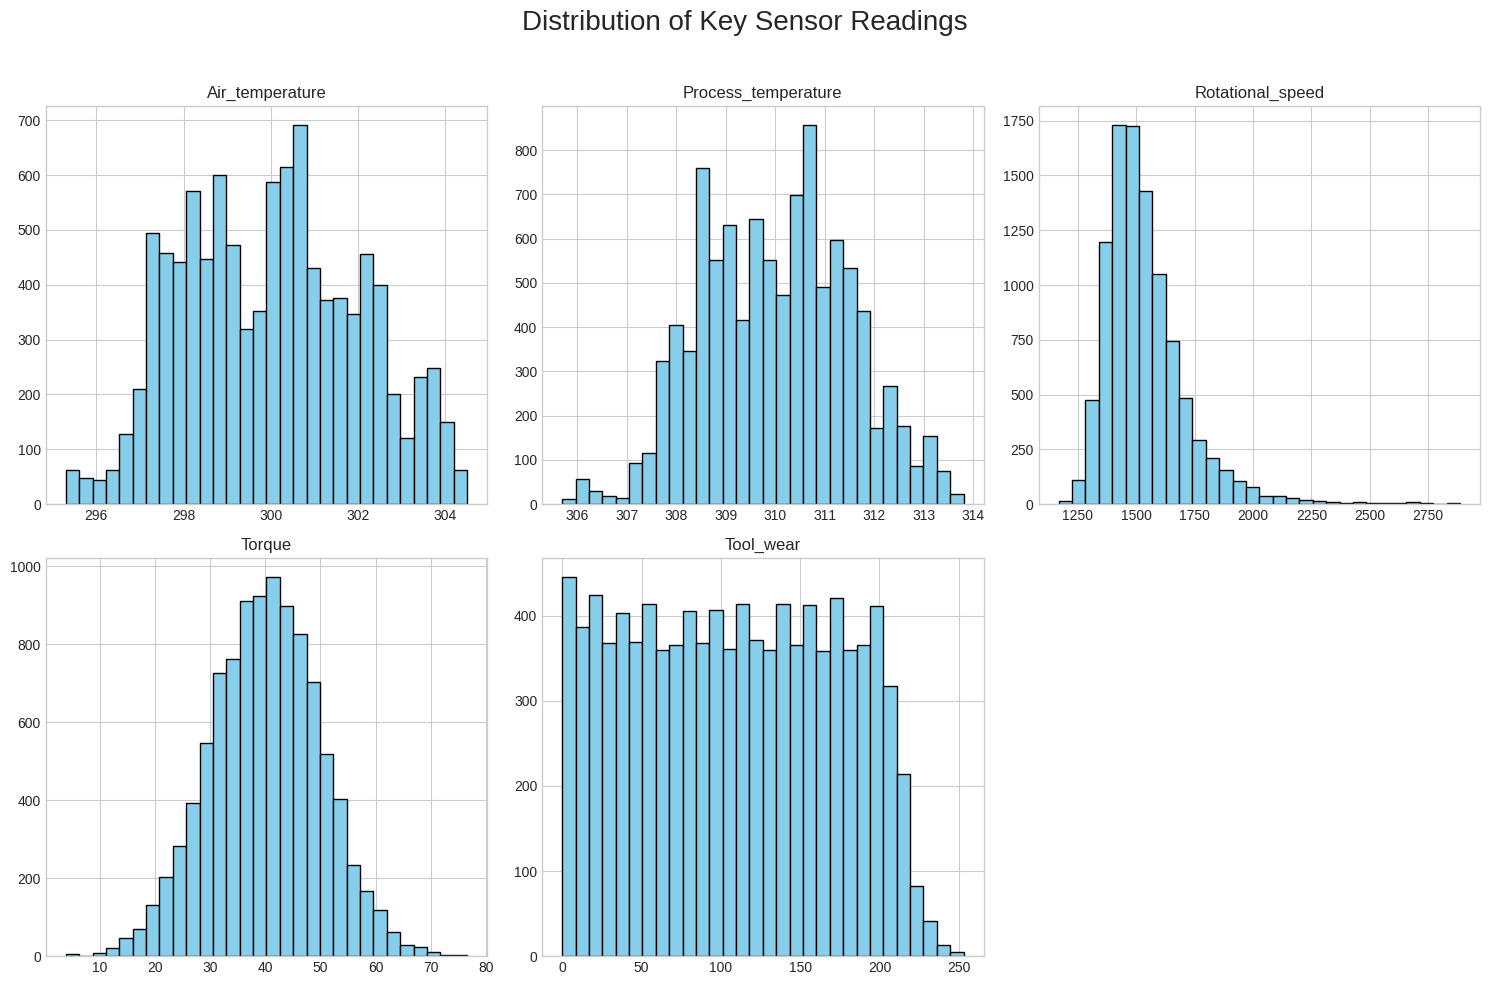

In [9]:
# Visualize Sensor Data Distributions
if not df.empty:
    numerical_features = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']
    
    df[numerical_features].hist(bins=30, figsize=(15, 10), layout=(2, 3), color='skyblue', edgecolor='black')
    plt.suptitle('Distribution of Key Sensor Readings', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

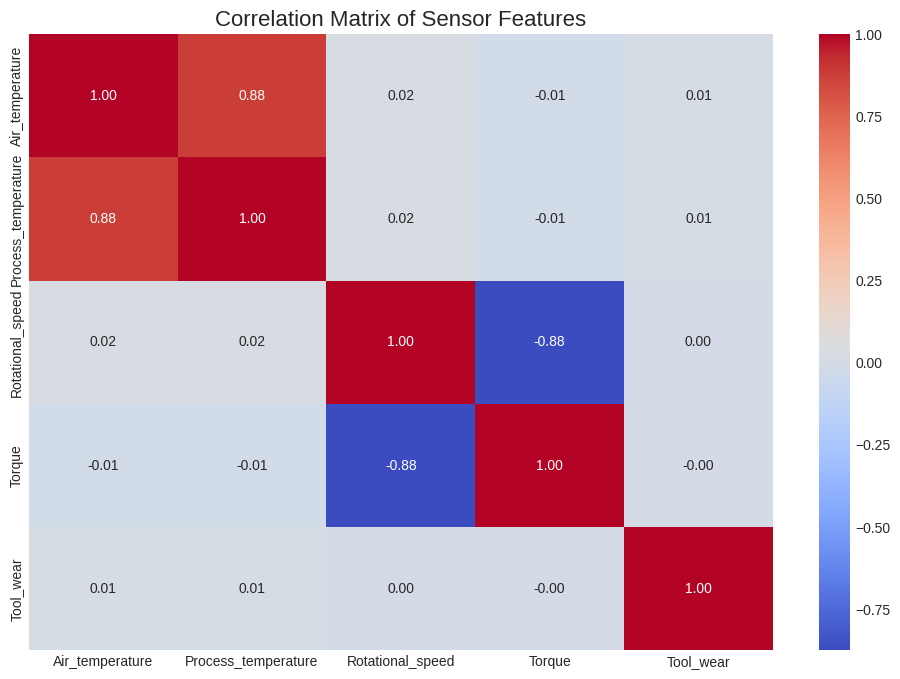

In [10]:
# Analyze Relationships Between Features (Correlation) 
if not df.empty:
    numerical_features = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']
    
    plt.figure(figsize=(12, 8))
    corr_matrix = df[numerical_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Sensor Features', fontsize=16)
    plt.show()


Comparing feature distributions for failure vs. non-failure cases...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


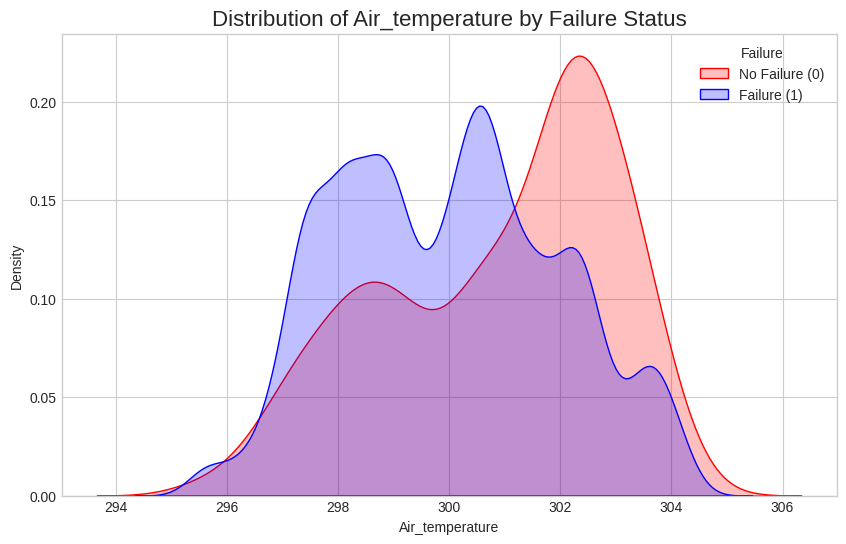

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


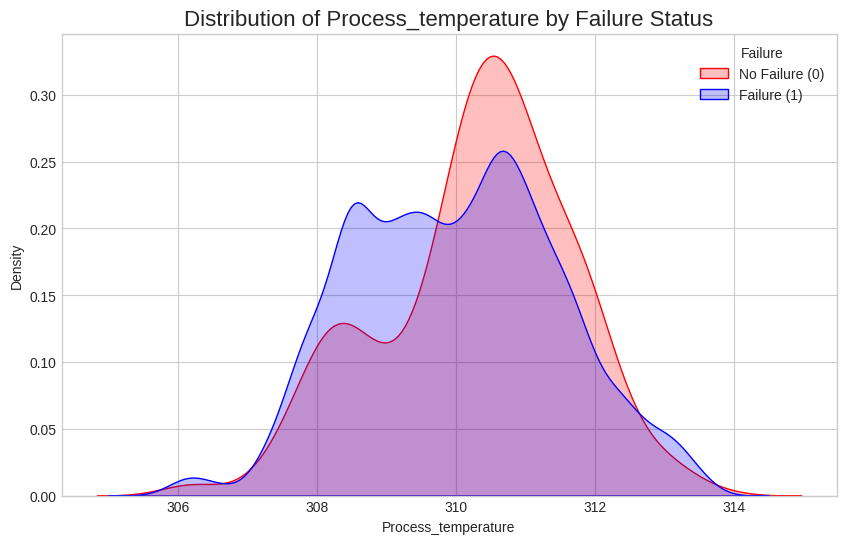

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


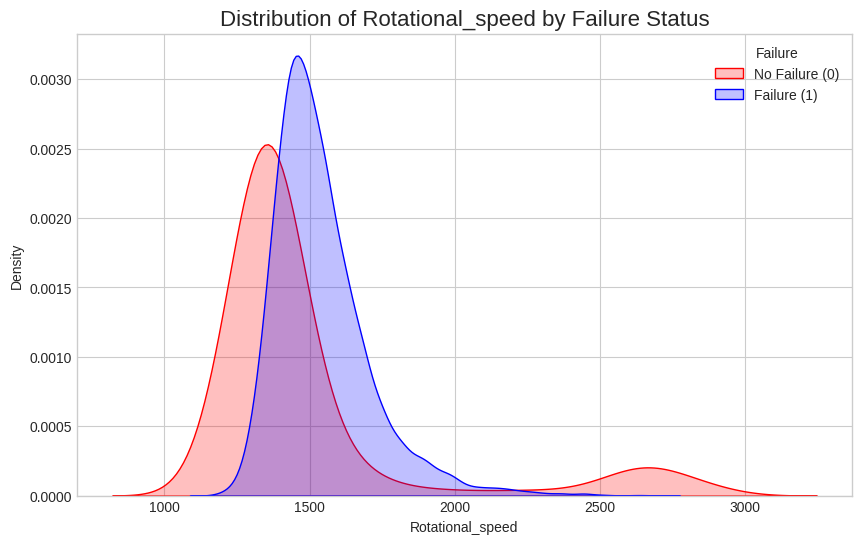

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


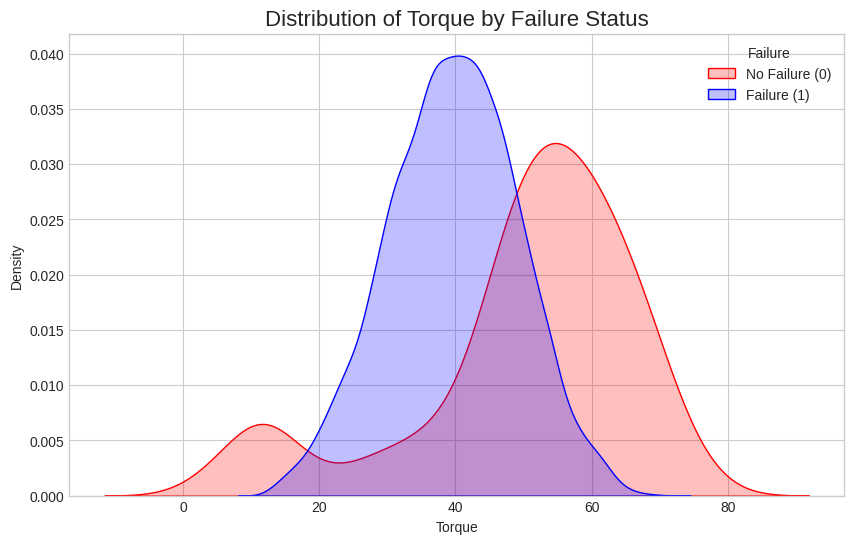

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


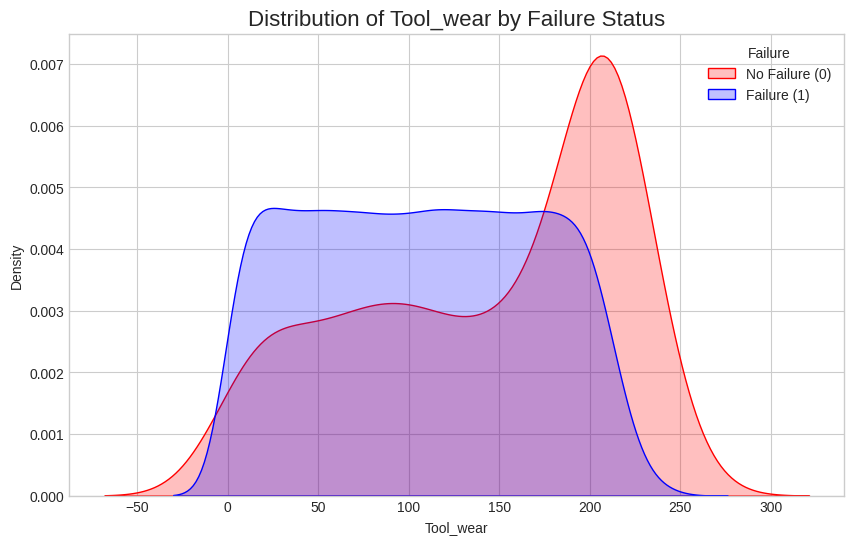

In [11]:
#  Compare Feature Distributions for Failure vs. Non-Failure 
if not df.empty:
    numerical_features = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']
    
    print("\nComparing feature distributions for failure vs. non-failure cases...")
    for feature in numerical_features:
        plt.figure(figsize=(10, 6))
        sns.kdeplot(data=df, x=feature, hue='Machine_failure', fill=True, palette={0: 'blue', 1: 'red'}, common_norm=False)
        plt.title(f'Distribution of {feature} by Failure Status', fontsize=16)
        plt.legend(title='Failure', labels=['No Failure (0)', 'Failure (1)'])
        plt.show()
        1654


# 4.Feature Engineering 

In [12]:
if not df.empty:
    df['Power'] = df['Torque'] * df['Rotational_speed']

    df['Temp_diff'] = df['Process_temperature'] - df['Air_temperature']

    df['Power_x_Wear'] = df['Power'] * df['Tool_wear']

    df['Temp_over_Power'] = df['Temp_diff'] / (df['Power'] + 1e-6)

    print("\n--- DataFrame with new advanced features created. ---")

    df_encoded = pd.get_dummies(df, columns=['Type'], drop_first=True, dtype=int)
    print("\n--- One-hot encoding complete. ---")

    cols_to_drop = ['Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
    X = df_encoded.drop(columns=cols_to_drop)
    y = df_encoded['Machine_failure']
    print("\n--- Feature and Target variables separated. ---")


--- DataFrame with new advanced features created. ---

--- One-hot encoding complete. ---

--- Feature and Target variables separated. ---


# 5. Splitting

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("--- Original Training Set Distribution ---")
print(y_train.value_counts())
print("\n--- Test Set Distribution ---")
print(y_test.value_counts())


--- Original Training Set Distribution ---
Machine_failure
0    7729
1     271
Name: count, dtype: int64

--- Test Set Distribution ---
Machine_failure
0    1932
1      68
Name: count, dtype: int64


# 6. Apply ADASYN 

In [14]:
# Apply ADASYN to the Training Data ONLY to prevent Leakage problem
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

print("\n--- Resampled Training Set Distribution ---")
print(pd.Series(y_train_resampled).value_counts())


--- Resampled Training Set Distribution ---
Machine_failure
0    7729
1    7656
Name: count, dtype: int64


# 7. Scale Numrical Features

In [15]:
numerical_features = [
    'Air_temperature', 'Process_temperature', 'Rotational_speed',
    'Torque', 'Tool_wear', 'Power', 'Temp_diff', 'Power_x_Wear', 'Temp_over_Power'
]
scaler = StandardScaler()

# Create copies 
X_train_scaled = X_train_resampled.copy()
X_test_scaled = X_test.copy()

# Fit the scaler ONLY on the resampled training data and transform it
X_train_scaled[numerical_features] = scaler.fit_transform(X_train_resampled[numerical_features])

X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

# 8. Model Training

In [16]:
# Initialize the models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Train each model on the resampled training data
for name, model in models.items():
    model.fit(X_train_scaled, y_train_resampled)
    print(f"{name} has been trained successfully.")

Logistic Regression has been trained successfully.
Random Forest has been trained successfully.
XGBoost has been trained successfully.


# 9. Evaluate Model Performance

In [17]:
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    print(f"\n--- Classification Report for {name} ---")
    print(classification_report(y_test, y_pred))


--- Classification Report for Logistic Regression ---
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1932
           1       0.21      0.78      0.34        68

    accuracy                           0.90      2000
   macro avg       0.60      0.84      0.64      2000
weighted avg       0.97      0.90      0.92      2000


--- Classification Report for Random Forest ---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1932
           1       0.45      0.79      0.58        68

    accuracy                           0.96      2000
   macro avg       0.72      0.88      0.78      2000
weighted avg       0.97      0.96      0.97      2000


--- Classification Report for XGBoost ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1932
           1       0.65      0.81      0.72        68

    accuracy                       

# 10. Hyperparameter Tuning

In [18]:
# Step 1. Define the parameter grid to search
# XGBoost parameters
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Step 2. Initialize the XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Step 3. Set up the randomized search with cross-validation
# n_iter controls how many different combinations to try
# cv is the number of cross-validation folds
# scoring='f1_weighted' is a good metric for imbalanced classes
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50,  # Try 50 different combinations
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
    verbose=1 # To see the progress
)

# Step 4. Fit the search on the scaled and resampled training data
print("Starting hyperparameter tuning with RandomizedSearchCV...")
random_search.fit(X_train_scaled, y_train_resampled)
print("Tuning complete.")

# Step 5. Get the best model and its parameters
print(f"\\nBest Parameters Found: {random_search.best_params_}")
best_xgb_model = random_search.best_estimator_

# Step 6. Evaluate the best model on the test set
print("\\n--- Classification Report for Tuned XGBoost ---")
y_pred_tuned = best_xgb_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred_tuned))


Starting hyperparameter tuning with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Tuning complete.
\nBest Parameters Found: {'subsample': 1.0, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}
\n--- Classification Report for Tuned XGBoost ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.69      0.79      0.74        68

    accuracy                           0.98      2000
   macro avg       0.84      0.89      0.86      2000
weighted avg       0.98      0.98      0.98      2000



# 11. Threshold Optimization

In [23]:
print(" Generating Final Predictions with the Optimal Threshold")

model = best_xgb_model

# The scaled test data
data_to_predict = X_test_scaled

# The optimal threshold for the analysis
optimal_threshold = 0.2

# 1. Get the predicted probabilities for the 'failure' class (class 1)
probabilities = model.predict_proba(data_to_predict)[:, 1]

# 2. Apply the optimal threshold to get the final 0 or 1 predictions
final_predictions = (probabilities >= optimal_threshold).astype(int)

print(f"\\nGenerated {len(final_predictions)} predictions using a threshold of {optimal_threshold}.")
print("These can now be used to flag machines for maintenance.")

# Add the predictions to original test dataframe to see which machines are flagged
X_test_with_predictions = X_test.copy()
X_test_with_predictions['Predicted_Failure'] = final_predictions

print("\\n--- First 5 Machines in the Test Set with Predictions ---")
print(X_test_with_predictions.head())

# You can now see which specific machines have a 'Predicted_Failure' of 1
print("\\n--- Machines Flagged for Maintenance ---")
print(X_test_with_predictions[X_test_with_predictions['Predicted_Failure'] == 1])

print(f"Model Accuracy with a 0.2 Threshold ")
print(classification_report(y_test, final_predictions))

 Generating Final Predictions with the Optimal Threshold
\nGenerated 2000 predictions using a threshold of 0.2.
These can now be used to flag machines for maintenance.
\n--- First 5 Machines in the Test Set with Predictions ---
      Air_temperature  Process_temperature  Rotational_speed  Torque  \
2997            300.5                309.8              1345    62.7   
4871            303.7                312.4              1513    40.1   
3858            302.5                311.4              1559    37.6   
951             295.6                306.3              1509    35.8   
6463            300.5                310.0              1358    60.4   

      Tool_wear    Power  Temp_diff  Power_x_Wear  Temp_over_Power  Type_L  \
2997        153  84331.5        9.3    12902719.5         0.000110       1   
4871        135  60671.3        8.7     8190625.5         0.000143       1   
3858        209  58618.4        8.9    12251245.6         0.000152       1   
951          60  54022.2   

In [24]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, final_predictions)

print(f"Model Accuracy with a 0.2 Threshold: {accuracy:.2%}")

Model Accuracy with a 0.2 Threshold: 97.05%
